In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import torch
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
from pytorch_lightning import Trainer

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from pathlib import Path

from dataset import MushroomBodyDataset 
from rnn import NeuralRNNModule

import json
import pandas as pd

%load_ext autoreload
%aimport dataset, rnn
%autoreload 1

In [2]:
DATA_DIR = Path('../data')

X_train_file = DATA_DIR / 'X-train-exp-time-series-from-distribution.npy'
Y_train_file = DATA_DIR / 'Y-train-from-distribution.npy'
train_dataset = MushroomBodyDataset(X_train_file, Y_train_file)
print(f'Train dataset size: {len(train_dataset)}')

X_val_file = DATA_DIR / 'X-val-exp-time-series-from-distribution.npy'
Y_val_file = DATA_DIR / 'Y-val-from-distribution.npy'
val_dataset = MushroomBodyDataset(X_val_file, Y_val_file)
print(f'Val dataset size: {len(val_dataset)}')

X_test_file = DATA_DIR / 'X-test-exp-time-series-from-distribution.npy'
Y_test_file = DATA_DIR / 'Y-test-from-distribution.npy'
test_dataset = MushroomBodyDataset(X_test_file, Y_test_file)
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 18000
Val dataset size: 4500
Test dataset size: 4500


# Hyperparams

In [3]:
hparams = {
    'batch_size': 64,
    'lr': 0.0001,
    'non_linearity': 'tanh',
    'max_epochs': 25,
    'min_epochs': 1
}

# Create Dataloaders

In [4]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=hparams['batch_size'],
    shuffle=False, 
    num_workers=4
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=hparams['batch_size'],
    shuffle=False, 
    num_workers=4
)

# Instantiate Model

In [5]:
model = NeuralRNNModule(
    masked=False,                          # if using masks for Wxh and Whh
    lr=hparams['lr'],                      # learning rate
    input_dim=15,                          # input dim
    hidden_dim=15,                         # hidden dim
    non_linearity=hparams['non_linearity'] # relu or tanh
)

model.hparams

"lr":            0.0001
"masked":        False
"non_linearity": tanh

In [6]:
# Check that the forward pass does what I expect
batch = next(iter(train_dataloader))
output = model(batch['dan'])
output.shape    # (batch, nodes)

torch.Size([64, 15])

### Check the Weight initialisation:

In [7]:
def plot_matrix(matrix, labels, title, cbar_title=None, size=[8,8], switch=False):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(matrix)


    plt.yticks(range(len(labels)), labels)
    plt.xticks(range(len(labels)), labels)
    plt.title(title)
    if switch:
        plt.xlabel('Target')
        plt.ylabel('Source')
    else:
        plt.xlabel('Source')
        plt.ylabel('Target')
        
    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            col = 'white' if matrix[i, j] < matrix.max()/2 else 'black'
            text = ax.text(j, i, int(matrix[i, j]),
                           ha="center", va="center", color=col)

    # Create colorbar
    if cbar_title is not None:
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel(cbar_title, rotation=-90, va="bottom")

    plt.tight_layout()
    plt.show()

greek_lobes = [
    r"$\alpha'_1$", r"$\alpha'_2$", r"$\alpha'_3$", 
    r'$\alpha_1$', r'$\alpha_2$', r'$\alpha_3$', 
    r"$\beta'_1$", r"$\beta'_2$",
    r'$\beta_1$', r'$\beta_2$', 
    r'$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$'
]

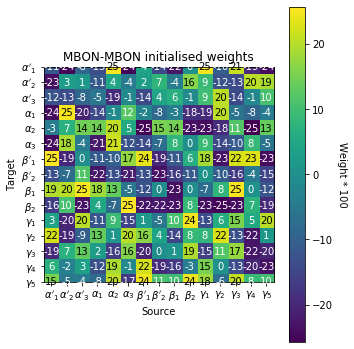

In [8]:
M = model.rnn.W_hh.weight.detach().numpy() * 100
plot_matrix(
    M, 
    greek_lobes, 
    'MBON-MBON initialised weights', 
    'Weight * 100',
    switch=False,
    size=[5,5]
)

# Train Model

In [9]:
logger = TensorBoardLogger("tb_logs", name="rnn_av", default_hp_metric=False)

In [10]:
logger.log_hyperparams(hparams)

In [11]:
trainer = Trainer(
    logger=logger,
    max_epochs=hparams['max_epochs'],
    min_epochs=hparams['min_epochs'],
#     callbacks=[EarlyStopping(monitor='val/loss')]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [12]:
trainer.fit(model, train_dataloader, val_dataloader)


  | Name     | Type      | Params
---------------------------------------
0 | rnn      | NeuralRNN | 480   
1 | loss_fcn | MSELoss   | 0     
---------------------------------------
480       Trainable params
0         Non-trainable params
480       Total params
0.002     Total estimated model params size (MB)


Epoch 0:  80%|███████▉  | 282/353 [00:04<00:01, 56.84it/s, loss=0.128, v_num=3] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  80%|███████▉  | 282/353 [00:05<00:01, 55.88it/s, loss=0.0881, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 2:  80%|███████▉  | 282/353 [00:05<00:01, 55.04it/s, loss=0.0571, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 3:  80%|███████▉  | 282/353 [00:06<00:01, 45.05it/s, loss=0.0358, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 4:  80%|███████▉  | 282/353 [00:04<00:01, 58.38it/s, loss=0.0237, v_num=3] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  80%|███████▉  | 282/353 [00:05<00:01, 47.59it/s, loss=0.0176, v_num=3] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  80%|███████▉  | 282/353 [00:04<00:01, 59.00it/s, loss=0.0146, v_num=3] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  80%|███████▉  | 282/353 [00:04<00:01, 65.77it/s, loss=0.0131, v_num=3] 
Validating: 0it [00:00, ?it/s]
Epoch 8:  80%|███████▉  | 282/353 [00:04<00:01, 68.16it/s, loss=0.0124, v_num=3] 
Validating: 0it [0

/anaconda3/envs/i2dl/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


Epoch 23:  29%|██▊       | 101/353 [00:18<00:46,  5.39it/s, loss=0.0107, v_num=3]

# Save model

In [13]:
MODEL_PATH = Path('../models/rnn_av.pt')

torch.save(model.state_dict(), MODEL_PATH)

# Load model (optional)

In [15]:
# Load model for inference using:

MODEL_PATH = Path('../models/rnn_av.pt')

model = NeuralRNNModule(
    masked=False,                          # if using masks for Wxh and Whh
    lr=hparams['lr'],                      # learning rate
    input_dim=15,                          # input dim
    hidden_dim=15,                         # hidden dim
    non_linearity=hparams['non_linearity'] # relu or tanh
)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

NeuralRNNModule(
  (rnn): NeuralRNN(
    (W_xh): Linear(in_features=15, out_features=15, bias=True)
    (W_hh): Linear(in_features=15, out_features=15, bias=True)
    (activation): Tanh()
  )
  (loss_fcn): MSELoss()
)

# Load Connectomics (for comparison)

In [16]:
mbon2mbon_connectome = np.load('../data/mbon-connectomics.npy')

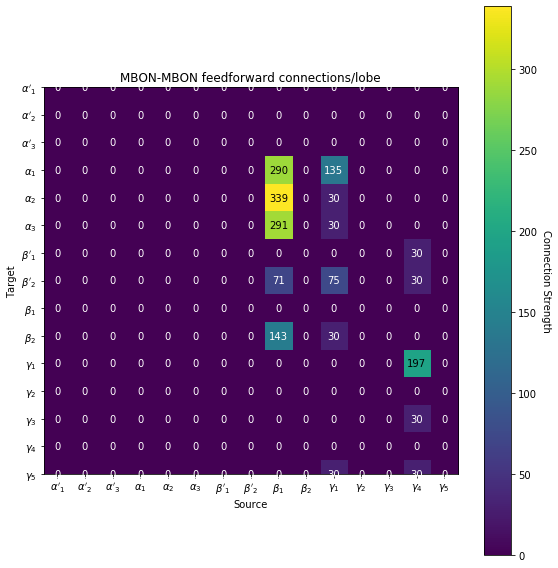

In [17]:
plot_matrix(
    mbon2mbon_connectome, 
    greek_lobes, 
    'MBON-MBON feedforward connections/lobe', 
    'Connection Strength'
)

# Visualise the trained weights

In [18]:
def normalise(m):
    if m.min() < 0:
        return (m - m.min() )/ (m.max() - m.min())
    
    return m / m.max()

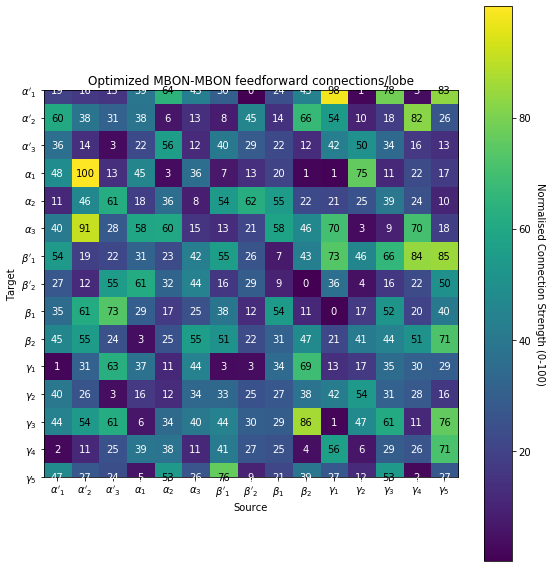

In [19]:
# multiply by 100 for visulisation purposes
M = normalise(np.abs(
        model.rnn.W_hh.weight.detach().numpy())
    )* 100
plot_matrix(
    M, 
    greek_lobes, 
    'Optimized MBON-MBON feedforward connections/lobe', 
    'Normalised Connection Strength (0-100)'
)

# Further Testing and Evaluation

In [20]:
 model.eval()

NeuralRNNModule(
  (rnn): NeuralRNN(
    (W_xh): Linear(in_features=15, out_features=15, bias=True)
    (W_hh): Linear(in_features=15, out_features=15, bias=True)
    (activation): Tanh()
  )
  (loss_fcn): MSELoss()
)

In [21]:
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=1,
    shuffle=False, 
    num_workers=4
)

In [22]:
gt = []
pred = []

test_loss = 0
for batch in test_dataloader:
    x = batch['dan']
    y = batch['mbon']
    y_pred = model(x)

    gt.append(y.detach().numpy().squeeze())
    pred.append(y_pred.squeeze().detach().numpy())

    
gt = np.array(gt)
pred = np.array(pred)

gt.shape, pred.shape, y_pred.shape

((4500, 15), (4500, 15), torch.Size([1, 15]))

Text(0.5, 1.0, 'Shape of the generated time series')

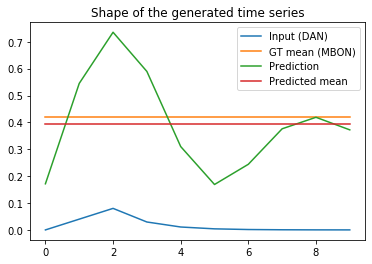

In [69]:
compartment = 1

output_ts = model.rnn(x)[0][0,:,compartment]
output_ts = output_ts.detach().numpy().squeeze()

plt.figure()
plt.plot(x[0,:,compartment], label='Input (DAN)')
plt.plot(y[0,compartment] * np.ones(10), label='GT mean (MBON)')
plt.plot(output_ts, label='Prediction')
plt.plot(y_pred.detach().numpy()[0,compartment] * np.ones(10), label='Predicted mean')
plt.legend()
plt.title('Shape of the generated time series')

## MSE

In [48]:
mse = np.sum((gt - pred) ** 2, axis = 0)/ gt.shape[0]
mse.mean()

0.010659993

In [49]:
lobes = np.array(["alpha'1", "alpha'2", "alpha'3", 'alpha1', 'alpha2', 'alpha3',
       "beta'1", "beta'2", 'beta1', 'beta2', 'gamma1', 'gamma2', 'gamma3',
       'gamma4', 'gamma5'])

mse_rnn = {}

for i, lobe in enumerate(lobes):
    mse_rnn[lobe] = mse[i]

## Compare MSE with linear models

In [50]:
RESULTS_DIR = Path('../results')

with open( RESULTS_DIR / 'canonical_linear_model_testing_data_mse.json', "r") as file:
    mse_canonical = json.load(file)

with open( RESULTS_DIR / 'crossed_linear_model_testing_data_mse.json', "r") as file:
    mse_crossed = json.load(file)
    
mse_df = pd.concat(
    [
        pd.Series(mse_canonical, name='canonical mse'), 
        pd.Series(mse_crossed, name='crossed mse'),
        pd.Series(mse_rnn, name='rnn mse') 
    ],
    axis=1
)


mse_df.describe()

,canonical mse,crossed mse,rnn mse
count,15.000000,15.000000,15.000000
mean,0.010724,0.009613,0.010660
std,0.011561,0.010431,0.011301
min,0.001789,0.001702,0.001823
25%,0.003226,0.003102,0.003468
50%,0.007856,0.006767,0.008097
75%,0.014011,0.012247,0.013767
max,0.046932,0.042517,0.046361


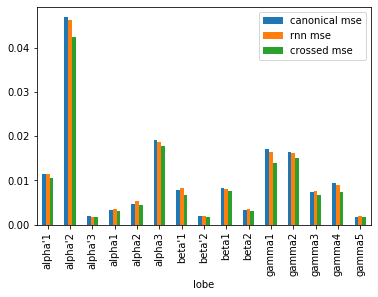

In [51]:
mse_df["lobe"] = mse_df.index
mse_df.plot(x="lobe", y=["canonical mse", "rnn mse", "crossed mse"], kind="bar")
plt.show()

## R squared

In [52]:
# calculate the r^2 for each output
# use this formula https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score
# 1 - (residual sum of squares) / (total sum of squares)

# total sum of squares: remove mean, square and sum
tss = np.sum((gt - gt.mean(axis=0))**2, axis=0)

# risidual sum of squares or the sum of residual errors
rss = np.sum((gt - pred)**2, axis =0)

r_squared = 1 - rss / tss

In [54]:
r_squared_rnn = {}

for i, lobe in enumerate(lobes):
    r_squared_rnn[lobe] = r_squared[i]

In [55]:
RESULTS_DIR = Path('../results')

with open( RESULTS_DIR / 'canonical_linear_model_testing_data_rsquared.json', "r") as file:
    rsquared_canonical = json.load(file)

with open( RESULTS_DIR / 'crossed_linear_model_testing_data_rsquared.json', "r") as file:
    rsquared_crossed = json.load(file)
    
rsquared_df = pd.concat(
    [
        pd.Series(rsquared_canonical, name='canonical rsquared'), 
        pd.Series(rsquared_crossed, name='crossed rsquared'),
        pd.Series(r_squared_rnn, name='rnn rsquared') 
    ],
    axis=1
)


rsquared_df.describe()

,canonical rsquared,crossed rsquared,rnn rsquared
count,15.000000,15.000000,15.000000
mean,0.008607,0.097670,-0.012419
std,0.016126,0.051286,0.060771
min,-0.001425,0.041054,-0.144329
25%,0.000645,0.058496,-0.052492
50%,0.003183,0.088328,0.016485
75%,0.006583,0.118609,0.031600
max,0.061727,0.199372,0.045228


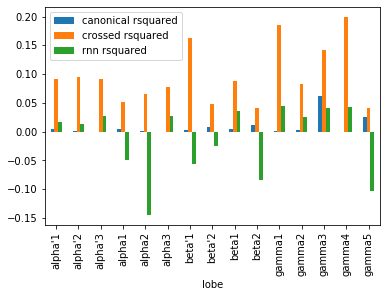

In [56]:
rsquared_df["lobe"] = rsquared_df.index
rsquared_df.plot(x="lobe", y=["canonical rsquared", "crossed rsquared", "rnn rsquared"], kind="bar")
plt.show()